# GANs &ndash; Part 1: Generation

Author: Sebastian Bujwid <bujwid@kth.se>

Refer to [./README.md](./README.md) for general comments.

---

## Scope

- Implementing a GAN model
- Training a GAN on two toy 2-D datasets:
    - Guassian blobs
    - Swiss roll
    
## Objectives

The point of this part of the practical is to get yourself familiar with a GAN model.
You are expected to learn technical implementation details of a GAN but also get a better feeling of the challenges of GAN training.
As this practical uses simple 2-D data, it will be easy to understand what the model does and what it has learned.

## GAN

A GAN model introduced by 
[Goodfellow _et al._ (2014)](https://papers.nips.cc/paper/2014/hash/5ca3e9b122f61f8f06494c97b1afccf3-Abstract.html)
consists of two networks trained in adversary, a generator and a discriminator.
The generator's goal is to produce realistic samples while the discriminator tries to tell apart the real data samples from the fake samples produced by the generator.
The better the generator gets at generating samples, the more difficult discriminator's job is.

Note that as GAN contain two separate networks, each trained to be better than the other, the training dynamics can be quite different from standard supervised training. It's not uncommon to observe the losses go up and down during training, as one of the networks get better than the other.

## Technical details

This Notebook has some `assert`s or checks which you can use to test your implementation of some of the functions. However, keep in mind that passing those checks does not necessarily mean that everything is correct!

Some of the `assert`s verify whether shapes of tensors are as expected. Those shapes, however, do not necessarily have to be as expected to have a correct implementation. You are, of course, free to do things differently but make sure you know what you're doing!

---

In [1]:
try:
    from omegaconf import OmegaConf
except ModuleNotFoundError:
    %pip install omegaconf
    from omegaconf import OmegaConf

In [130]:
import numpy as np

import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tqdm

In [3]:
seed = 42

# Toy datasets

In [4]:
def dataset_swiss_roll(n_samples, seed):
    x, _ = sklearn.datasets.make_swiss_roll(n_samples, noise=0.5, random_state=seed)
    x = x[:, [0, 2]]
    return x / np.max(np.abs(x)) + np.array([0., 5.])

In [5]:
def dataset_s_curve(n_samples, seed):
    x, _ = sklearn.datasets.make_s_curve(n_samples, noise=0.15, random_state=seed)
    x = x[:, [0, 2]]
    return x

In [6]:
def dataset_blobs(n_samples, seed):
    x, _ = sklearn.datasets.make_blobs(
        n_samples=n_samples, n_features=2,
        centers=8, cluster_std=0.8,
        random_state=seed)
    return x

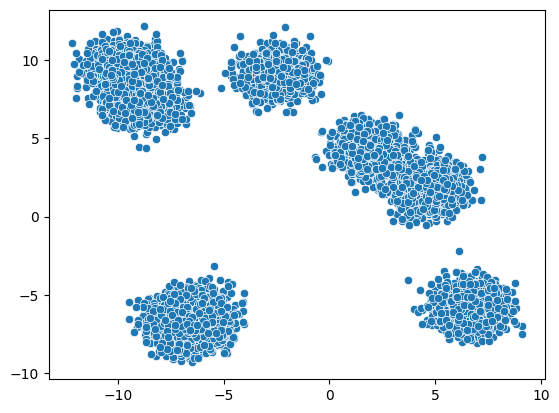

In [7]:
x = dataset_blobs(n_samples=10000, seed=seed)
sns.scatterplot(x=x[:, 0], y=x[:, 1])
plt.show()

# Loss functions

In [8]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers, stax
from jax import jit

If you have a GPU, make sure you're using it!

In [9]:
jax.devices()

[CpuDevice(id=0)]

### (Task) Implement `sigmoid_cross_entropy` function

First, we'll implement a `sigmoid_cross_entropy` function that transforms the input logits with the sigmoid function and computes the cross-entropy loss.

The function should compute the following:

$$loss(t, l) = - \left[t \cdot \log S(l) + (1 - t) \cdot \log(1 - S(l)) \right]$$

where `t` represents the input target value; `l` the logit; and `S(x)` the sigmoid function:
$$S(x) = \frac{1}{1 + e^{-x}}$$

Note, that the sigmoid & cross-entropy can be thought of as separate function but here we expect it to be a single function.

**Question:**
- Is there any (objective) potential benefit of implementing the combination of sigmoid & cross-entropy as a single function?

We have the following:
\begin{equation}
\log S(l) = -\log(1 + \exp(-l)),\qquad \log (1-S(l)) = \log(1 - 1 / (1 + \exp(-l))) =...= - l - \log(1 + \exp(-l))
\end{equation}
so that 
\begin{align*}
loss(t, l) &= - \left[t \cdot \log S(l) + (1 - t) \cdot \log(1 - S(l)) \right]\\
&= t\log(1+\exp(-l)) + (1 - t)(l + \log(1 + \exp(-l)))\\
&= (1-t)l + \log(1 + \exp(-l))\\
&= (1-t)l - \log(S(l))
\end{align*}
Using the above equation leads to less expensive computation of sigmoid and cross entropy than just a simple function composition as in the given formula. As seen below, log_sigmoid is already implemented in jax in a numerically stable way :). 

In [44]:
def sigmoid_cross_entropy(*, targets, logits):
    assert targets.shape == logits.shape
    
    loss = (1 - targets)*logits - jax.nn.log_sigmoid(logits)
    
    assert loss.shape == logits.shape, \
        'cross-entropy loss is not expected here to be averaged over samples'
    return loss

In [45]:
sigmoid_cross_entropy(targets=jnp.array(1.), logits=jnp.array(0.))

Array(0.6931472, dtype=float32, weak_type=True)

In [46]:
sigmoid_cross_entropy(targets=jnp.array([[1.], [1.]]), logits=jnp.array([[0.], [0.]]))

Array([[0.6931472],
       [0.6931472]], dtype=float32)

#### (Task) Test `sigmoid_cross_entropy`

In [47]:
targets = np.array([0, 1, 0, 1, 1])
logits = np.array([0.55, -0.22, 0.8, 0.1, -0.42])
returned = sigmoid_cross_entropy(targets=targets, logits=logits)
expected_mean_ce_loss = np.array(0.9110423)

np.testing.assert_allclose(expected_mean_ce_loss, jnp.mean(returned))

### (Optional task) Numerically stable `sigmoid_cross_entropy` loss

Feel free to skip this task (or maybe try it at the end after completing everything else?).
You should (hopefully) be able to complete the rest of the practical even if your `sigmoid_cross_entropy` function is not able to handle very large or small values, producing NaNs.
Note that you typically do not want your model to internally (hidden features, logits, etc.) operate on very large numbers. Such a behavior might indicate some "issues with training".
However, it does not have to imply any major issues and sometimes might be even expected.

Numerical stability of implementation can be important and it is good to be at least familiar with what are the main roots of numerical stability issues and how to address them, what are the common "tricks".


**(Optional) task:**
- Can your function compute the value for $t=0$ and $l=10000.0$ or do you get NaNs?
- Do you understand what is the source of the numerical instability (NaNs)?
    - Hint: Think of computing $\log(e^x)$ for $x = 10^9$, for example. The value of the expressions is impossible to calculate by `np.log(np.exp(x))` (returns inf/NaN) but we know that $\log(e^x)=x$.
    
- Can you compute by hand the (almost?) exact value of the function for the inputs as above? **Try to transform the formula manually and see if you can implement a more numerically stable `sigmoid_cross_entropy` function that works with very large or small numbers.**

- Note that expressions in math are usefually written in the form that is the most readable or intuitive. However, that form might not necessarily be the best to be implemented. Not just because of numerical stability but also in terms of speed or memory usage.

- Hopefully, in the future you'd be able to foresee numerical stability issues and address them! The operations like `log` and `exp` you have to be especially careful about!


In [48]:
sigmoid_cross_entropy(targets=jnp.array(0.),
                      logits=jnp.array(10000.))

Array(10000., dtype=float32, weak_type=True)

### GAN: objectives

In this practical, we're going to use the GAN training objectives as introduced by
[Goodfellow _et al._ (2014)](https://papers.nips.cc/paper/2014/hash/5ca3e9b122f61f8f06494c97b1afccf3-Abstract.html)
(note that $D(x) \in (0, 1)$):

<br>
<div align="center">(discriminator)</div>

$$
-\mathbb{E}_{x \sim p_{\text{data}}(x)}
\left[
\log D(x)
\right]
%
-\mathbb{E}_{z \sim p_z(z)}
\left[
\log (1 - D(G(z)) )
\right]
$$


<br>
<div align="center">(generator: non-saturating objective)</div>

$$
-\mathbb{E}_{z \sim p_z(z)}
\left[
\log D(G(z))
\right].
$$

Note we use the **non-saturating** loss for the generator. The alternative is, of course, to have the generator optimize just the reverse of the discriminator's objective.
In the non-saturating loss, instead of training the generator to minimize the probability of the discriminator being correct, we maximize the probability of the discriminator incorrectly classifying generated samples as true.
Therefore, thanks to the formulation of non-saturating loss, the generator can learn (as it gets non-zero gradients) when the discriminator is very strong and correctly classifies generated samples as fake (that is when $log(1-D(G(z))$ would be close to 0).


Alternatively, there is a number of modified objectives for training GANs, such as for example:
- [WGAN](https://arxiv.org/abs/1701.07875)
- [WGAN-GP](https://papers.nips.cc/paper/2017/hash/892c3b1c6dccd52936e27cbd0ff683d6-Abstract.html)
- [LSGAN](https://openaccess.thecvf.com/content_ICCV_2017/papers/Mao_Least_Squares_Generative_ICCV_2017_paper.pdf)

### (Task) Implement discriminator's loss

Hint: use `sigmoid_cross_entropy` function

By looking at the formula for sigmoid and cross entropy we can "select" the terms corresponding to $\log(1-D(G(x))))$ and $\log(D(x))$ by supplying appropriate targets equal to 0 or 1. 

In [106]:
def discriminator_loss(*, real_logits, fake_logits):
    # NOTE: the inputs are expected to be logits, not probabilities!
    
    loss = jnp.mean(sigmoid_cross_entropy(targets=jnp.zeros_like(fake_logits), logits=fake_logits)) + \
           jnp.mean(sigmoid_cross_entropy(targets=jnp.ones_like(real_logits), logits=real_logits))
    
    assert loss.shape == (), \
        'discriminator loss is expected here to be averaged over samples'
    return loss

What result would you expect if both real & fake input logits were equal $0.0$?

Try out a couple of values! Does the function return what you would expect it to return?
What if you set the real logits high and fake logits low? What if it's vice-versa?

In [107]:
discriminator_loss(real_logits=jnp.array([[0.], [0.]]), fake_logits=jnp.array([[0.], [0.]]))

Array(1.3862944, dtype=float32)

In [108]:
discriminator_loss(real_logits=jnp.array([0., 0.]), fake_logits=jnp.array([0., 0.]))

Array(1.3862944, dtype=float32)

#### (Task) Test the discriminator loss

In [109]:
returned = discriminator_loss(
    real_logits=jnp.array([0.13, -0.11, -1.12, -0.02]),
    fake_logits=jnp.array([-0.88, 0.42, 0.42, -0.81])
)
expected = 1.5126383
np.testing.assert_almost_equal(returned, expected)

### (Task) Implement generator loss

Hint: Use `sigmoid_cross_entropy` function

We use the same trick for selecting terms in `sigmoid_cross_entropy` as above

In [114]:
def generator_loss(discriminator_fake_logits):
    # NOTE: the inputs are expected to be logits, not probabilities!
    loss = jnp.mean(sigmoid_cross_entropy(targets=jnp.ones_like(discriminator_fake_logits), logits=discriminator_fake_logits))
    #raise NotImplementedError('Task: implement!')
    #loss = NotImplemented
    
    assert loss.shape == (), \
        'discriminator loss is expected here to be averaged over samples'
    return loss

#### (Task) Testing the generator loss

What result would you expect for the output of the generator $G(z)$ (which is the input to $D(.)$) equal $0.0$?
Does the result match your expectation?

In [115]:
generator_loss(discriminator_fake_logits=jnp.array([[0.], [0.,]]))

Array(0.6931472, dtype=float32)

In [116]:
generator_loss(discriminator_fake_logits=jnp.array([0., 0.]))

Array(0.6931472, dtype=float32)

In [117]:
returned = generator_loss(discriminator_fake_logits=jnp.array([1.12, -0.12, 0., 0.42, -0.82,]))
expected = 0.68409014
np.testing.assert_allclose(expected, returned)

# Training

In [118]:
from utils import plot_losses

In [119]:
def iterable_dataset(key, data, batch_size):
    n_batches = len(data) // batch_size
    x_shuffled = jax.random.permutation(key, data)
    dataset = [x_shuffled[i * batch_size: (i + 1) * batch_size] for i in range(n_batches)]
    return dataset

In [120]:
def plot_losses(losses_dict):
    for key, vals in losses_dict.items():
        plt.plot(vals, label=key)
    plt.legend()
    plt.show()

In [121]:
def generate_and_plot_samples(key, real_data, generator_apply, gen_params, n_samples, input_noise_dim):
    noise = jax.random.normal(key, (n_samples, input_noise_dim))
    samples = generator_apply(gen_params, noise)
    sns.scatterplot(x=real_data[:, 0], y=real_data[:, 1], label='real data')
    sns.scatterplot(x=samples[:, 0], y=samples[:, 1], label='generated samples')
    plt.legend()
    plt.show()

In [122]:
def create_mlp(n_hid_layers, hid_dim, output_dim):
    layers = list(itertools.chain.from_iterable(
        [(stax.Dense(hid_dim), stax.Relu) for _ in range(n_hid_layers)]
    )) + [stax.Dense(output_dim)]
    mpl_init, mpl_apply = stax.serial(*layers)
    return mpl_init, mpl_apply

## (Task) Implement the `train_step` function

Note that the generator and discriminator's parameters should be updated individually.
Make sure that the generator's gradients and discriminator's gradients depend on the right "things".

In [ ]:
def create_and_train_gan(hparams, data, seed=seed):
    
    data_dim = data[0].shape[-1]
    
    # Create models
    
    if hparams.model_type == 'mlp':
        generator_init, generator_apply = create_mlp(
            n_hid_layers=hparams.generator.n_layers,
            hid_dim=hparams.generator.hidden_dim,
            output_dim=data_dim,
        )
        discriminator_init, discriminator_apply = create_mlp(
            n_hid_layers=hparams.discriminator.n_layers,
            hid_dim=hparams.discriminator.hidden_dim,
            output_dim=1,
        )
    else:
        raise NotImplementedError(f'model_type: {hparams.model_type}')
        
    # Initialize
    key = jax.random.PRNGKey(seed)
    key, key_gen, key_dis = jax.random.split(key, 3)
    
    input_noise_shape = (-1, hparams.input_noise_dim)
    data_shape = (-1, data_dim)
    _, gen_params = generator_init(key_gen, input_noise_shape)
    _, dis_params = discriminator_init(key_dis, data_shape)
    
    ## Initialize: optimizers
    gen_opt_init, gen_opt_update, gen_get_params = optimizers.adam(
        step_size=hparams.gen_lr, b1=hparams.beta1)
    dis_opt_init, dis_opt_update, dis_get_params = optimizers.adam(
        step_size=hparams.dis_lr, b1=hparams.beta1)
    gen_opt_state = gen_opt_init(gen_params)
    dis_opt_state = dis_opt_init(dis_params)
    
    
    # NOTE: can comment out @jax.jit for debugging but
    #       make sure to use it training as it will be much faster
    @jax.jit
    def train_step(step, gen_opt_state, dis_opt_state, noise, real_samples):
        gen_params = gen_get_params(gen_opt_state)
        dis_params = dis_get_params(dis_opt_state)
        
        #raise NotImplementedError('Task: implement!')
        
        # We need the gradient of the loss with respect to model parameters.
        # To that end, we define new loss functions which compose multiple functions
        # Note, we recompute fake_samples here. That seems wasteful to me but idk how to do it another way :c
        def gen_loss_from_gen_params(gen_params):
            fake_samples = generator_apply(gen_params, noise)
            fake_logits = discriminator_apply(dis_params, fake_samples)
            return generator_loss(fake_logits)
        
        def dis_loss_from_dis_params(dis_params):
            fake_samples = jax.lax.stop_gradient(generator_apply(gen_params, noise))
            fake_logits = discriminator_apply(dis_params, fake_samples)
            real_logits = discriminator_apply(dis_params, real_samples)
            return discriminator_loss(real_logits=real_logits, fake_logits)
        
        gen_loss, gen_grads = jax.value_and_grad(gen_loss_from_gen_params)(gen_params)
        dis_loss, dis_grads = jax.value_and_grad(dis_loss_from_dis_params)(dis_params)
        
        gen_opt_state = gen_opt_update(step, gen_grads, gen_opt_state)
        dis_opt_state = dis_opt_update(step, dis_grads, dis_opt_state)
        return (gen_loss, dis_loss), (gen_opt_state, dis_opt_state)
    
    # Training
    losses = {'gen': [], 'dis': []}

    total_step = 0
    for epoch in tqdm.tqdm(range(hparams.epochs)):
        key, key_data = jax.random.split(key)
        
        for batch_x in iterable_dataset(key=key_data, data=data, batch_size=hparams.batch_size):
            
            key, subkey = jax.random.split(key)
            noise = jax.random.normal(subkey, (hparams.batch_size, hparams.input_noise_dim))
            
            (gen_loss, dis_loss), (gen_opt_state, dis_opt_state) = train_step(
                step=total_step,
                gen_opt_state=gen_opt_state,
                dis_opt_state=dis_opt_state,
                noise=noise,
                real_samples=batch_x,
            )
            losses['gen'].append(gen_loss)
            losses['dis'].append(dis_loss)
            
            total_step += 1
            
        if epoch == 0 or (epoch < 100 and epoch % 10 == 9) or epoch % 100 == 99:
            print('-' * 30, 'epoch', epoch, '-' * 30)
            plot_losses(losses)
            key, subkey = jax.random.split(key)
            generate_and_plot_samples(
                subkey, data,
                generator_apply, gen_get_params(gen_opt_state),
                n_samples=256, input_noise_dim=hparams.input_noise_dim)

## (Task) Train the GAN model: simple blobs data

Below you can the output of my training. Can you get similar results?
Note that the output you get might not be exactly the same as the one below but given that the code skeleton already covers most of the details that could matter, it should be fairly similar.

**Questions:**
* Is the generator able to cover all of the blobs?
For the first ~300 epochs, the generator produces samples from only one of the blobs, after which we see a dramatic increase in generator performance by producing samples looking like the other blobs.
* Are the individual blobs well covered by the generated samples?
At the end of training, the generator produces samples seemingly originating from all blobs. However, the generated samples seem to be concentrated at the centers of the blobs.
* Can you observe mode collapse?
As previously mentioned, at the end of training samples cluster close to the centers of blobs. This could be seen as mode collapse, as the data distribution produces samples further from the modes more frequently.

  0%|          | 0/1000 [00:00<?, ?it/s]

------------------------------ epoch 0 ------------------------------


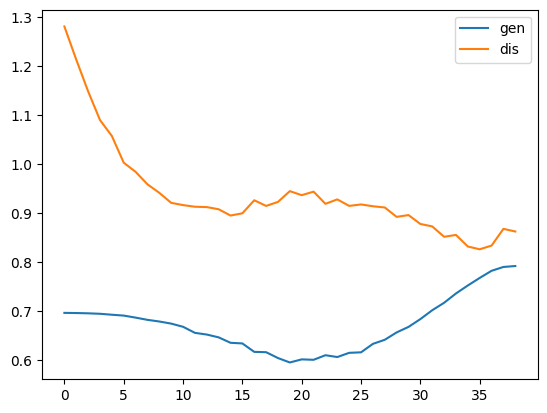

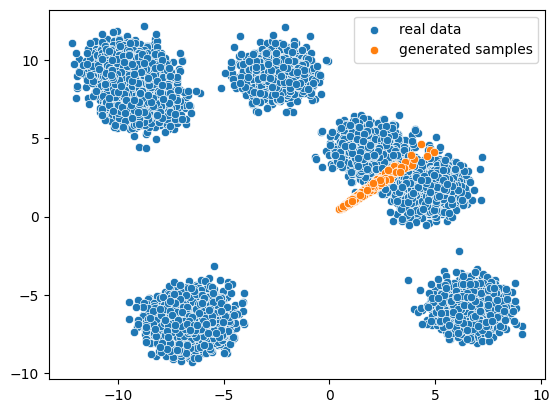

  1%|          | 9/1000 [00:03<04:42,  3.51it/s]

------------------------------ epoch 9 ------------------------------


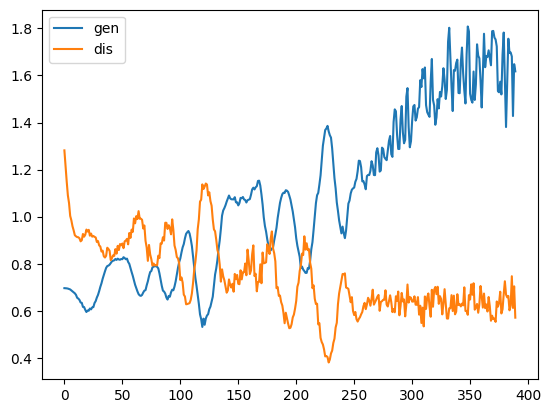

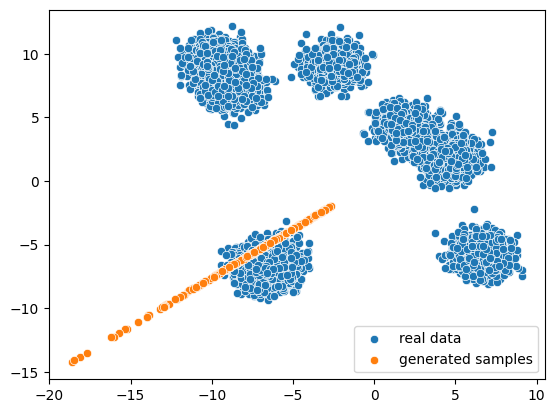

  2%|▏         | 19/1000 [00:06<05:11,  3.15it/s]

------------------------------ epoch 19 ------------------------------


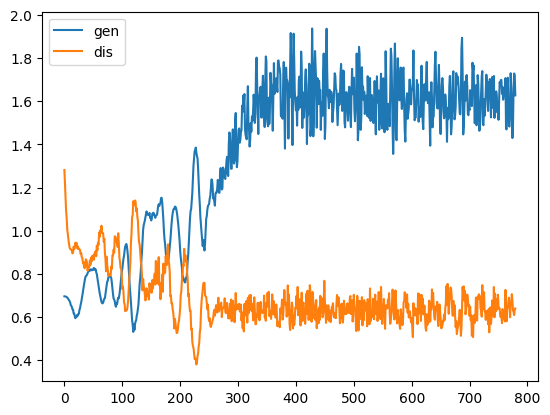

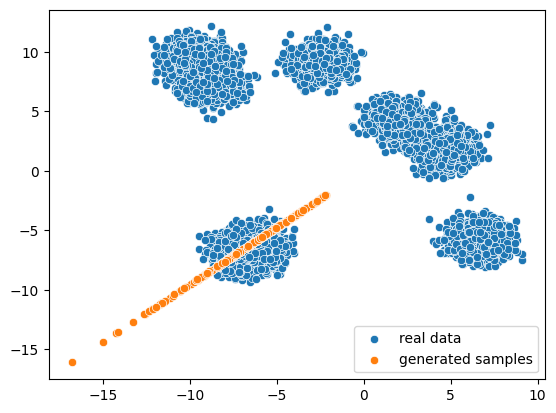

  3%|▎         | 29/1000 [00:09<04:47,  3.37it/s]

------------------------------ epoch 29 ------------------------------


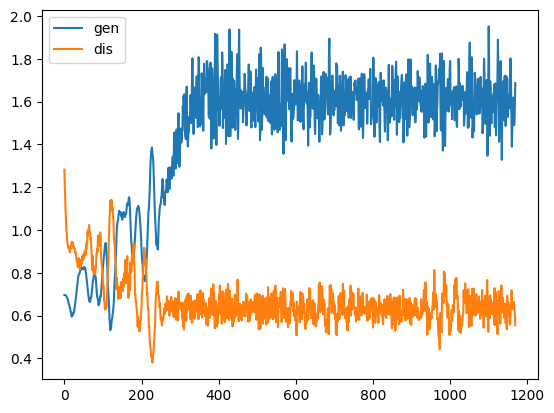

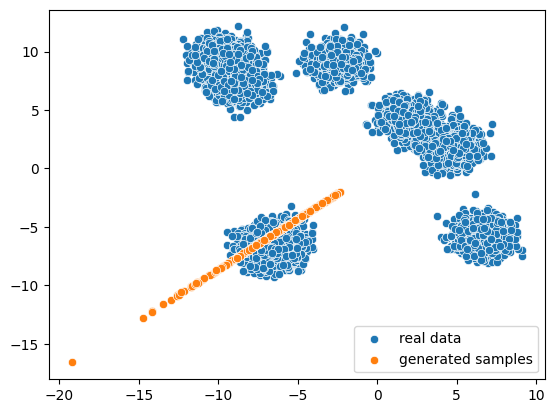

  4%|▍         | 39/1000 [00:13<04:32,  3.53it/s]

------------------------------ epoch 39 ------------------------------


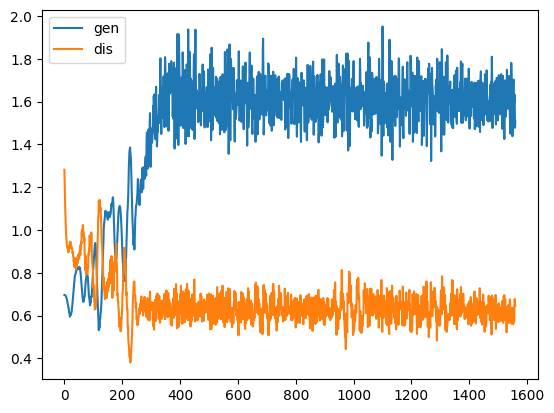

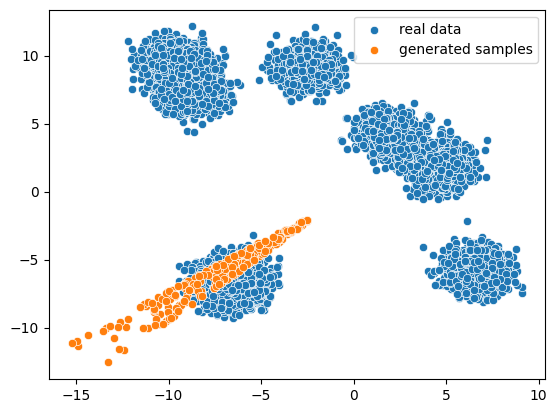

  5%|▍         | 49/1000 [00:16<04:56,  3.21it/s]

------------------------------ epoch 49 ------------------------------


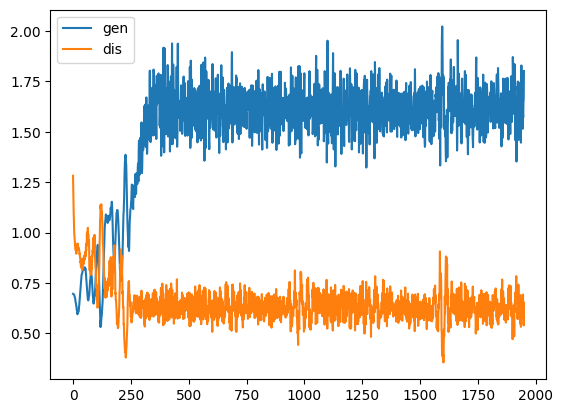

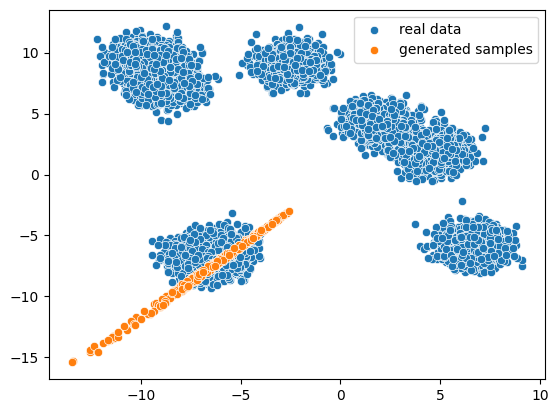

  6%|▌         | 59/1000 [00:19<04:34,  3.43it/s]

------------------------------ epoch 59 ------------------------------


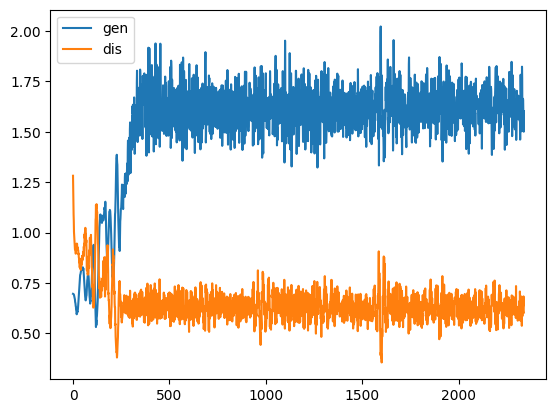

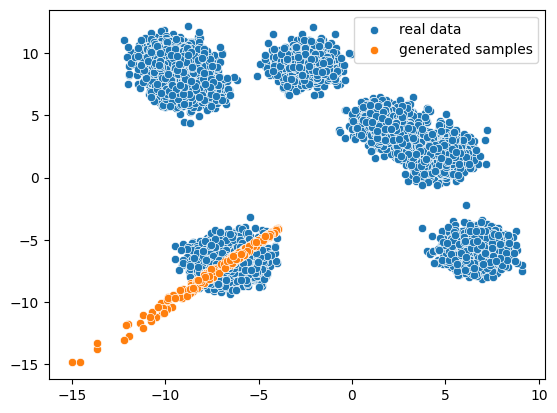

  7%|▋         | 69/1000 [00:22<04:22,  3.55it/s]

------------------------------ epoch 69 ------------------------------


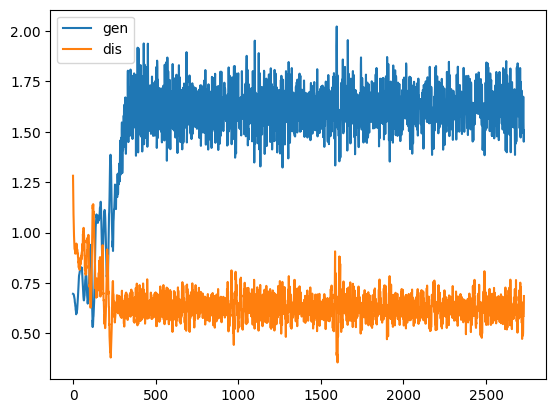

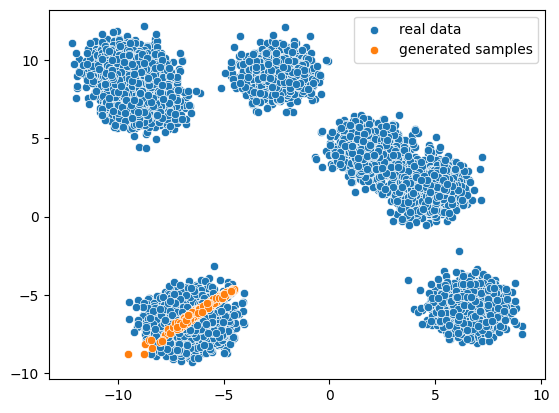

  8%|▊         | 79/1000 [00:26<04:27,  3.44it/s]

------------------------------ epoch 79 ------------------------------


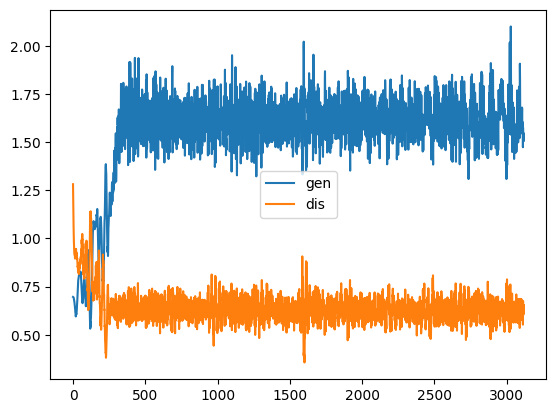

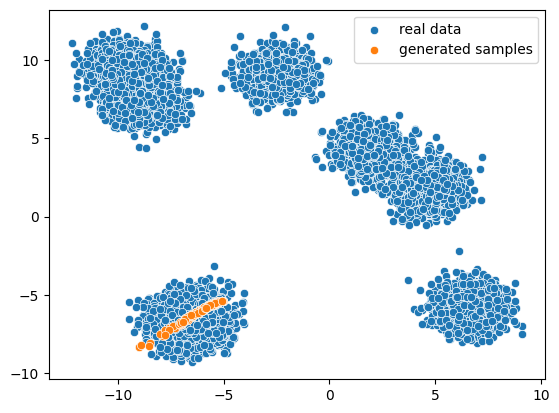

  9%|▉         | 89/1000 [00:29<04:11,  3.62it/s]

------------------------------ epoch 89 ------------------------------


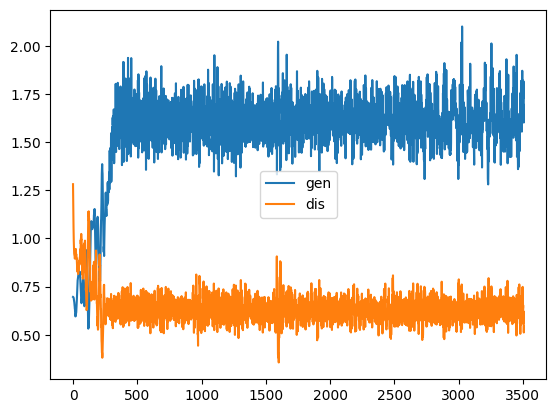

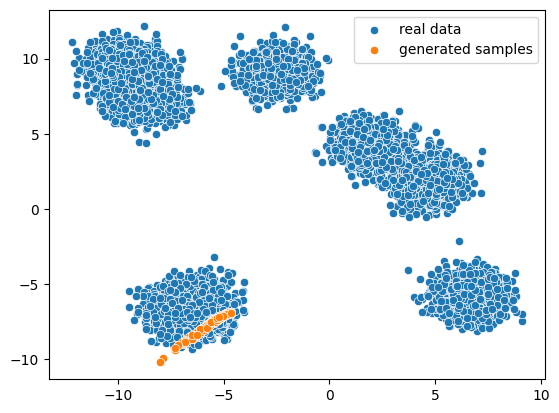

 10%|▉         | 99/1000 [00:32<04:05,  3.67it/s]

------------------------------ epoch 99 ------------------------------


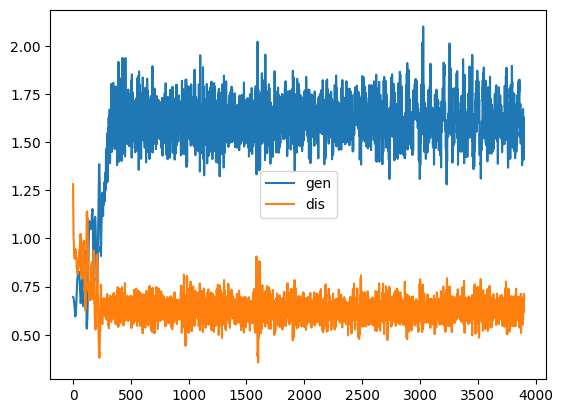

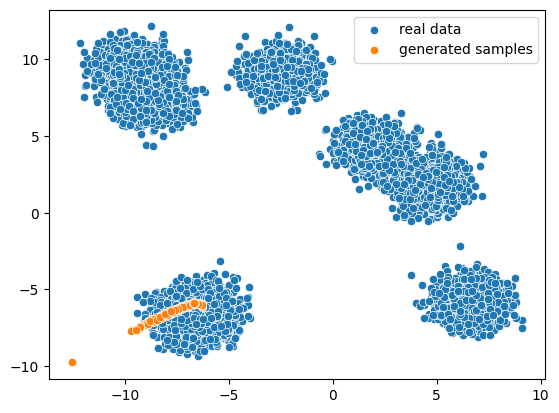

 20%|█▉        | 199/1000 [01:02<04:35,  2.90it/s]

------------------------------ epoch 199 ------------------------------


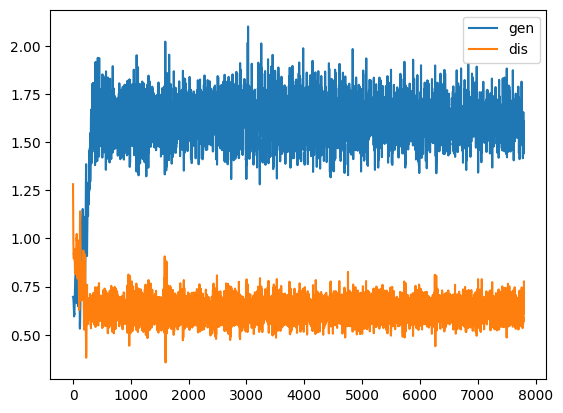

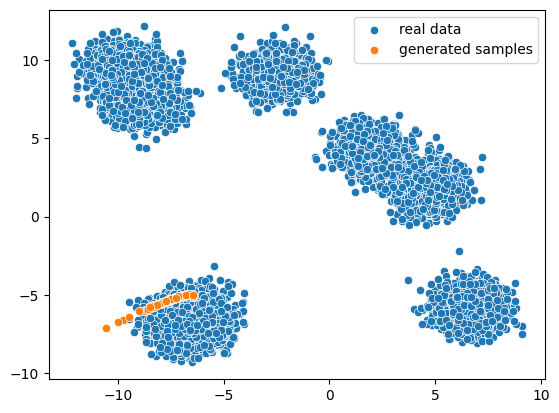

 30%|██▉       | 299/1000 [01:40<04:43,  2.48it/s]

------------------------------ epoch 299 ------------------------------


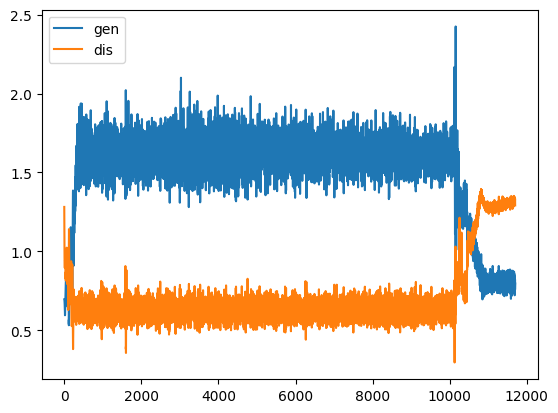

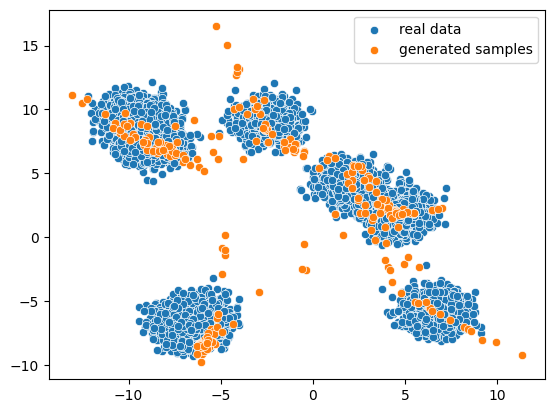

 40%|███▉      | 399/1000 [02:18<03:32,  2.83it/s]

------------------------------ epoch 399 ------------------------------


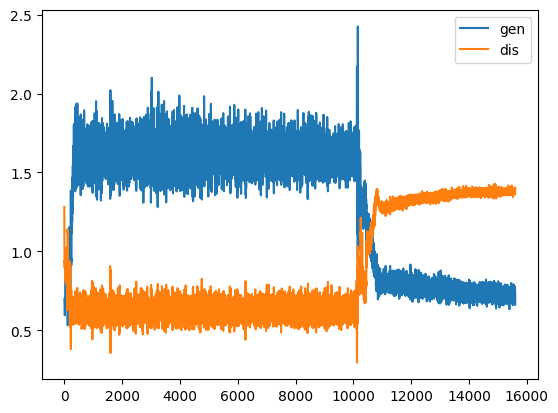

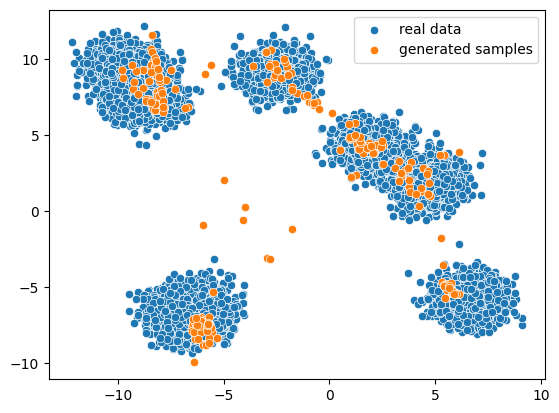

 50%|████▉     | 499/1000 [02:54<02:44,  3.04it/s]

------------------------------ epoch 499 ------------------------------


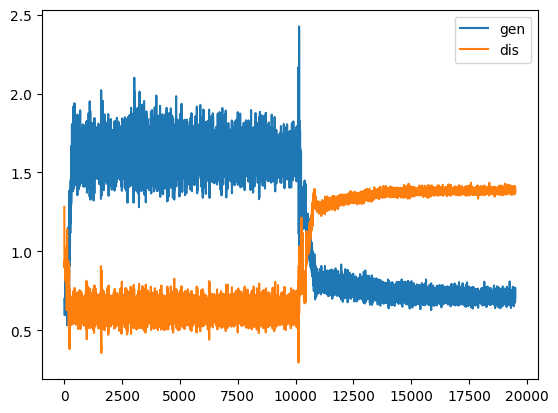

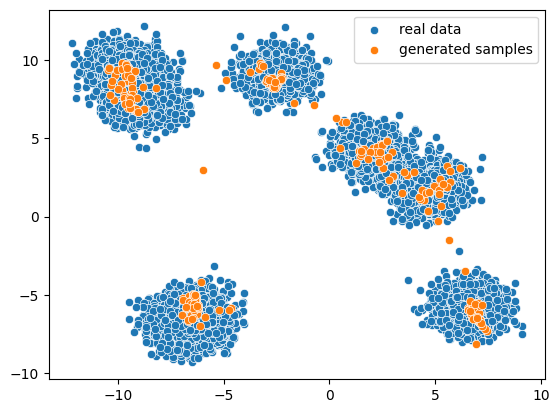

 60%|█████▉    | 599/1000 [03:32<02:22,  2.82it/s]

------------------------------ epoch 599 ------------------------------


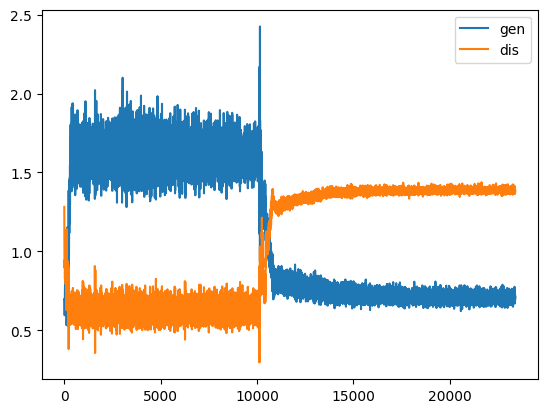

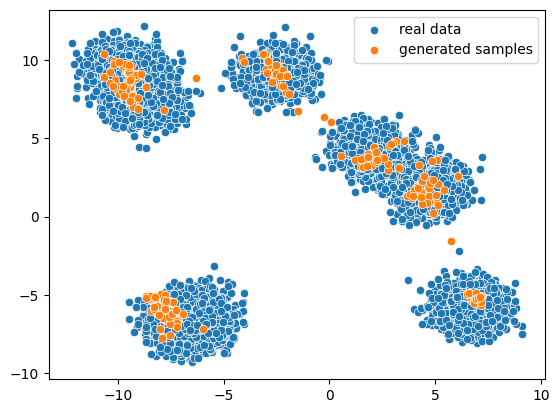

 70%|██████▉   | 699/1000 [04:12<01:54,  2.63it/s]

------------------------------ epoch 699 ------------------------------


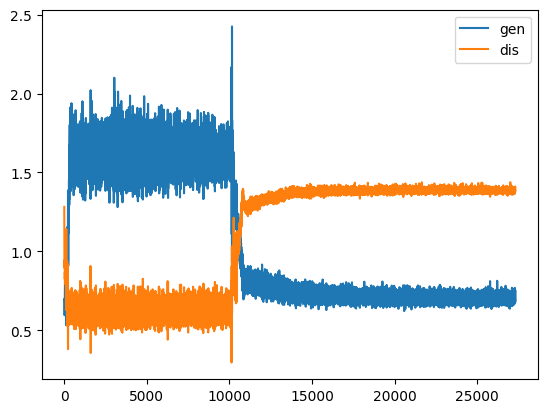

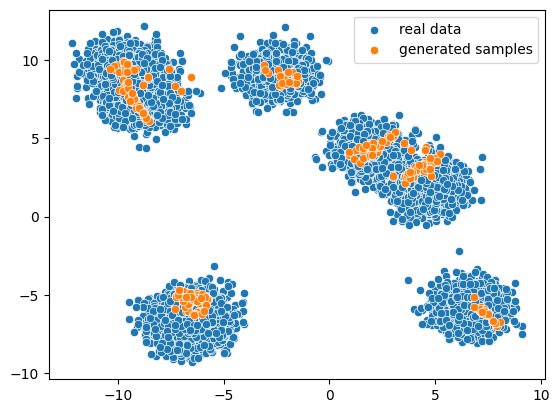

 80%|███████▉  | 799/1000 [04:48<01:12,  2.78it/s]

------------------------------ epoch 799 ------------------------------


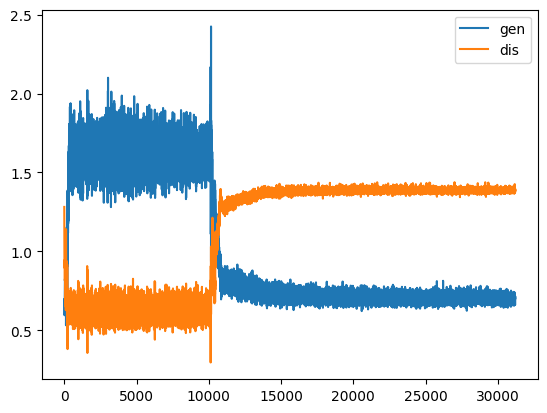

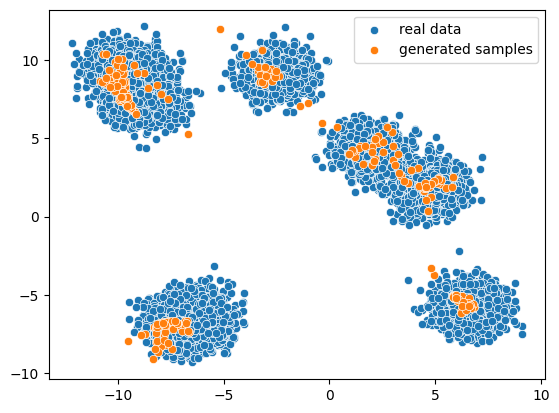

 90%|████████▉ | 899/1000 [05:27<00:42,  2.40it/s]

------------------------------ epoch 899 ------------------------------


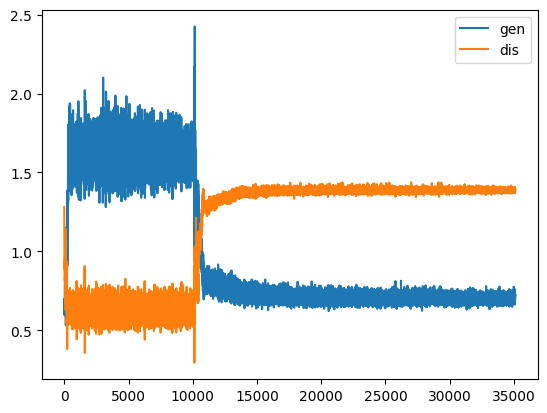

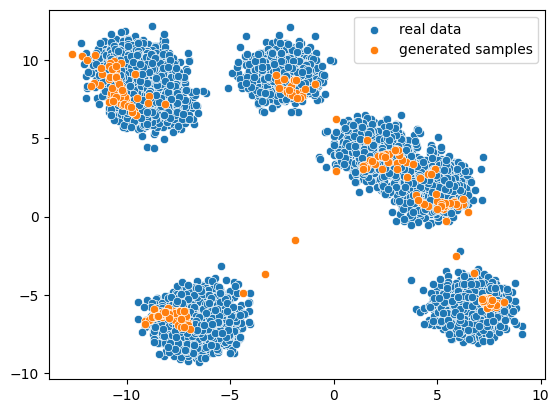

100%|█████████▉| 999/1000 [06:10<00:00,  2.64it/s]

------------------------------ epoch 999 ------------------------------


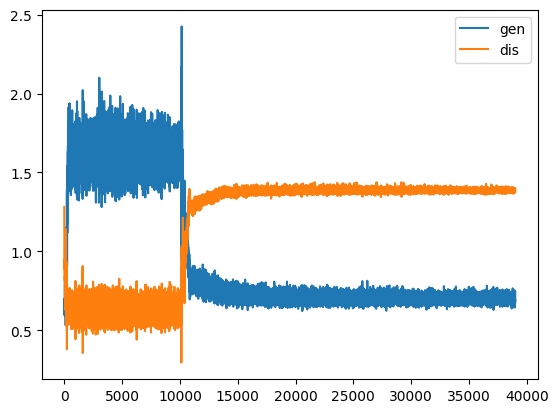

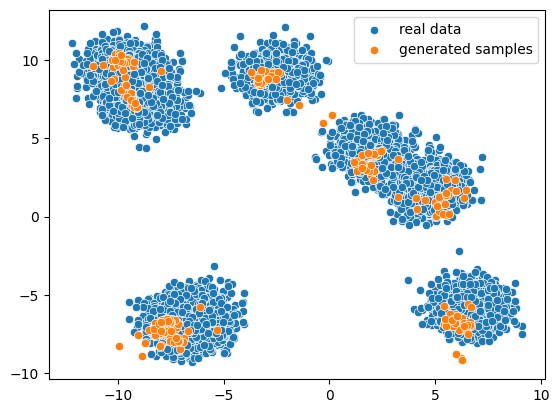

100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


In [132]:
hparams = OmegaConf.create({
    'epochs': 1000,
    'batch_size': 256,
    'gen_lr': 0.0001,
    'dis_lr': 0.0001,
    'beta1': 0.5,  # NOTE: important!
    'model_type': 'mlp',
    'generator': {
        'n_layers': 3,
        'hidden_dim': 512,
    },
    'discriminator': {
        'n_layers': 2,
        'hidden_dim': 512,
    },
    'input_noise_dim': 2,
})
create_and_train_gan(hparams, dataset_blobs(n_samples=10000, seed=seed), seed=seed)

  0%|          | 0/1000 [00:00<?, ?it/s]

------------------------------ epoch 0 ------------------------------


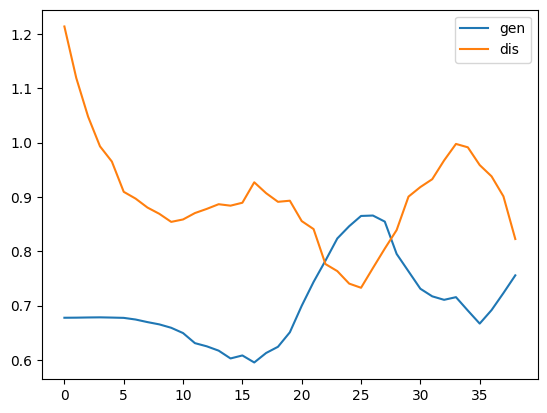

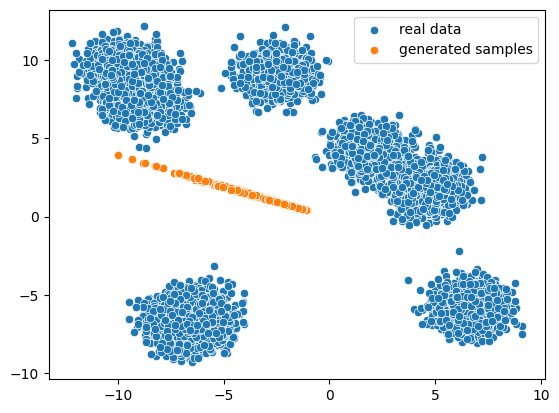

  1%|          | 9/1000 [00:06<10:36,  1.56it/s]

------------------------------ epoch 9 ------------------------------


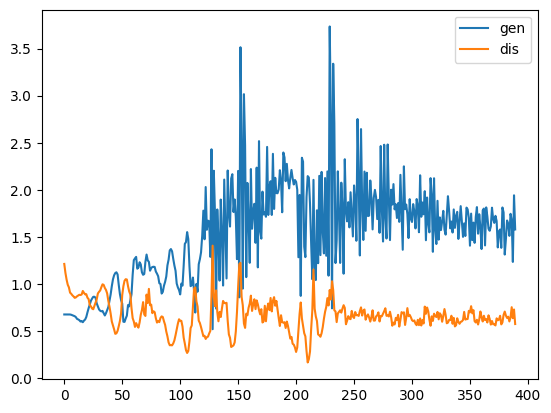

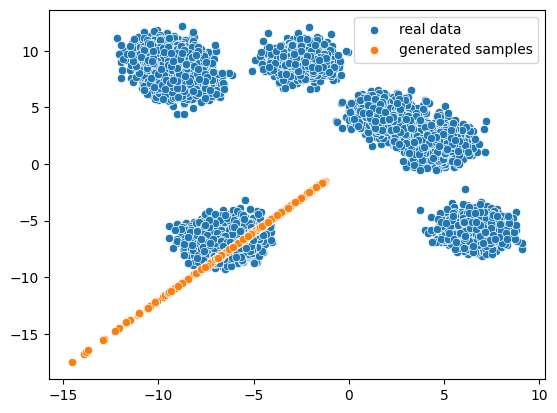

  2%|▏         | 19/1000 [00:14<11:39,  1.40it/s]

------------------------------ epoch 19 ------------------------------


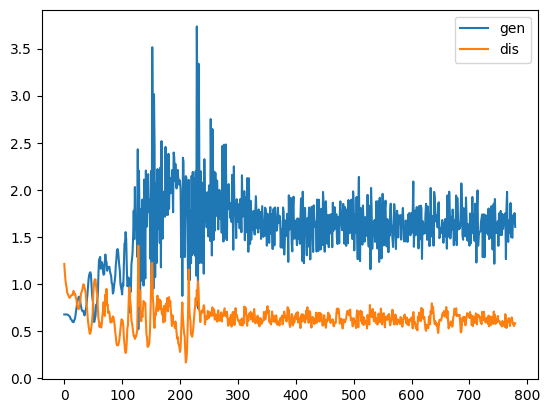

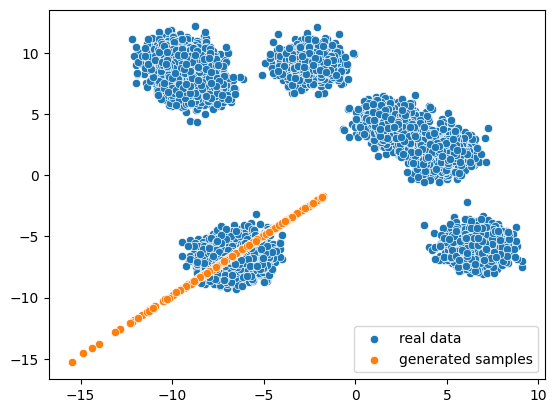

  3%|▎         | 29/1000 [00:21<10:37,  1.52it/s]

------------------------------ epoch 29 ------------------------------


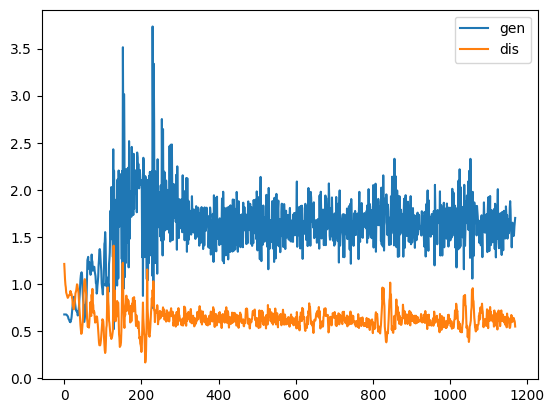

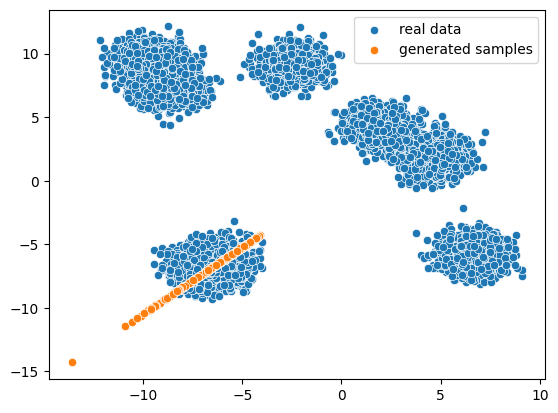

  4%|▍         | 39/1000 [00:28<11:04,  1.45it/s]

------------------------------ epoch 39 ------------------------------


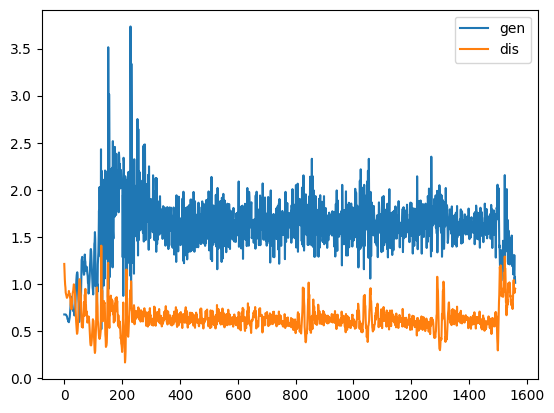

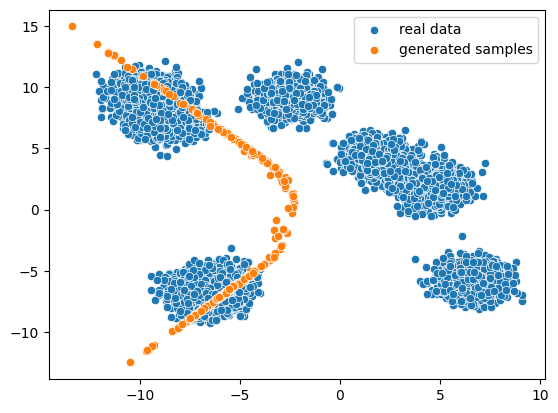

  5%|▍         | 49/1000 [00:36<11:46,  1.35it/s]

------------------------------ epoch 49 ------------------------------


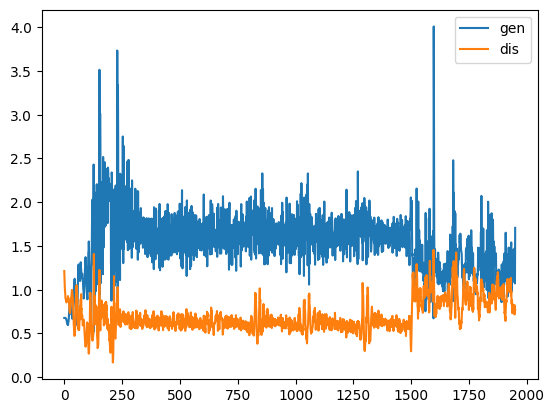

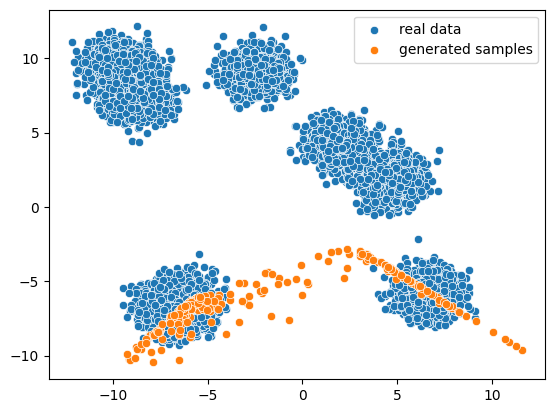

  6%|▌         | 59/1000 [00:43<10:37,  1.48it/s]

------------------------------ epoch 59 ------------------------------


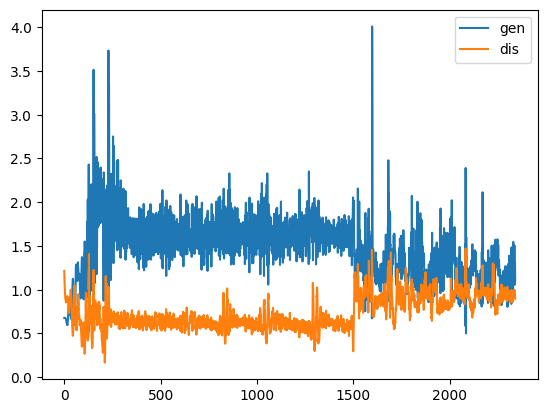

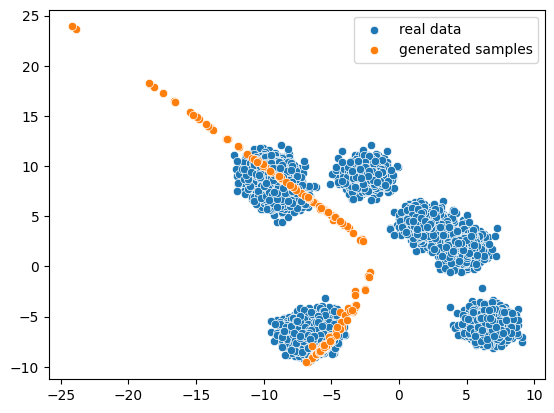

  7%|▋         | 69/1000 [00:50<10:54,  1.42it/s]

------------------------------ epoch 69 ------------------------------


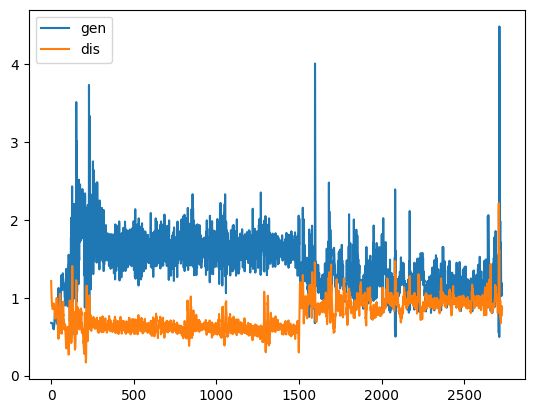

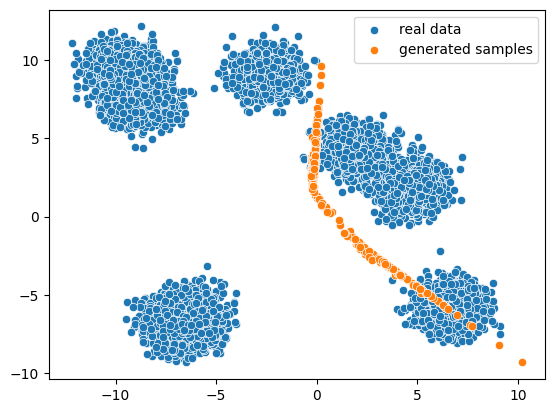

  8%|▊         | 79/1000 [00:58<11:26,  1.34it/s]

------------------------------ epoch 79 ------------------------------


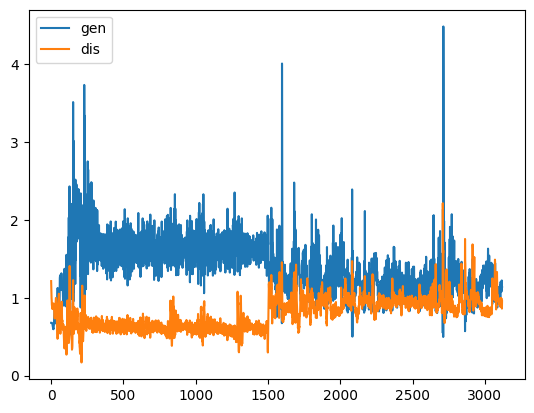

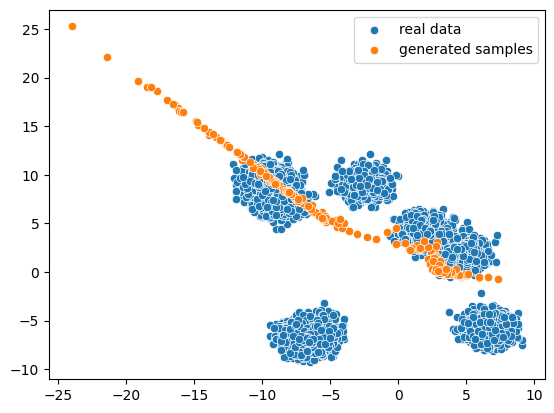

  9%|▉         | 89/1000 [01:07<12:06,  1.25it/s]

------------------------------ epoch 89 ------------------------------


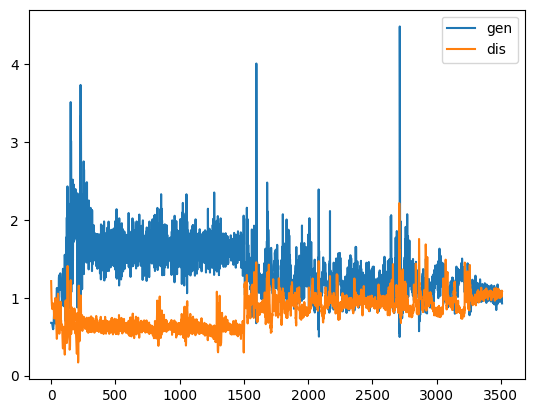

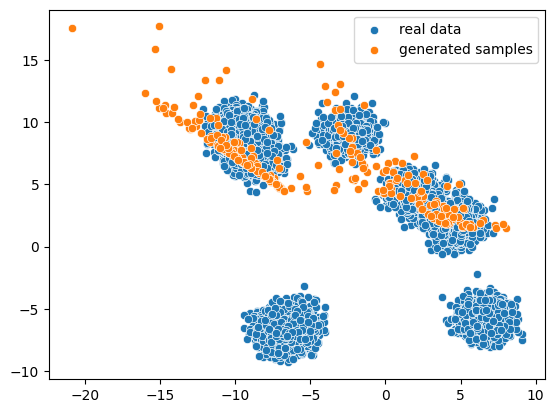

 10%|▉         | 99/1000 [01:15<12:35,  1.19it/s]

------------------------------ epoch 99 ------------------------------


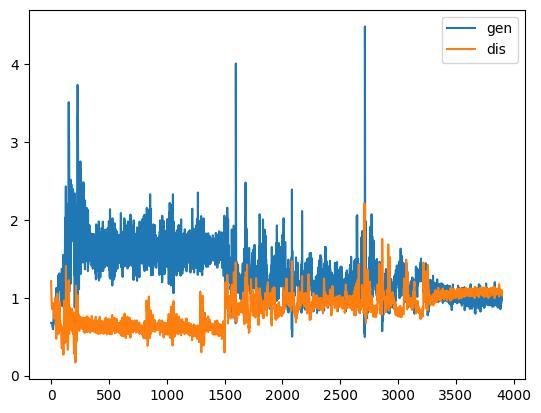

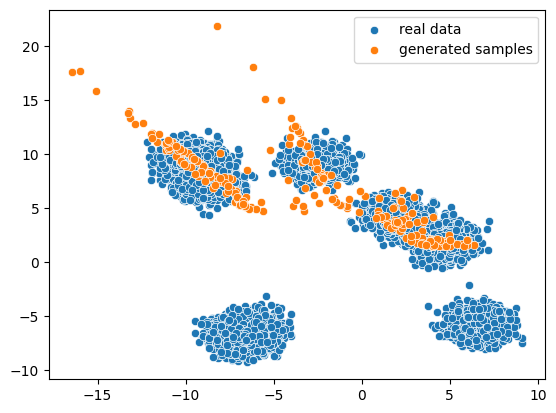

 20%|█▉        | 199/1000 [02:38<11:52,  1.12it/s]

------------------------------ epoch 199 ------------------------------


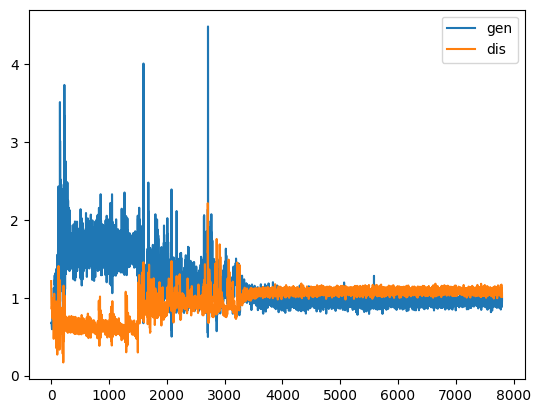

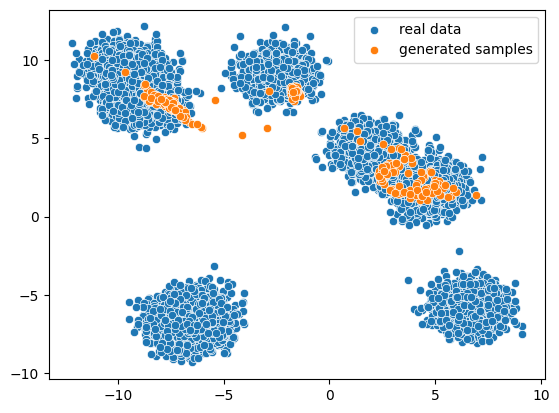

 30%|██▉       | 299/1000 [04:14<11:56,  1.02s/it]

------------------------------ epoch 299 ------------------------------


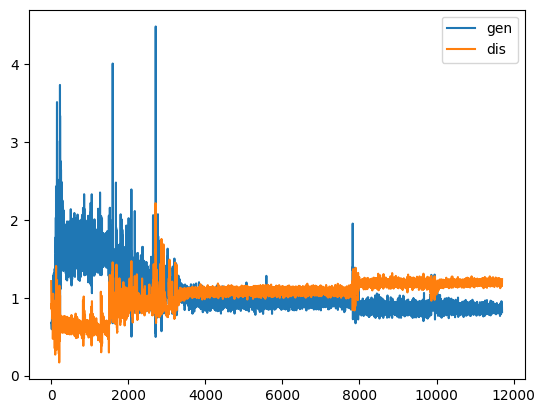

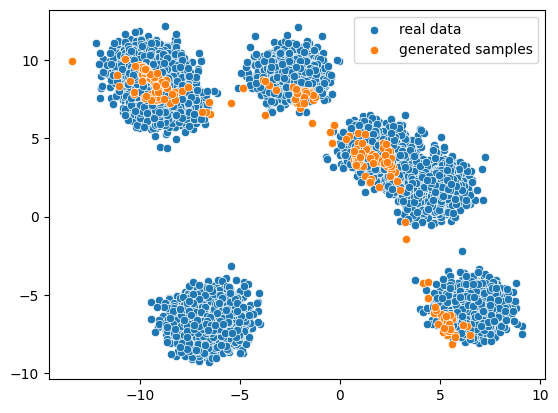

 40%|███▉      | 399/1000 [05:59<11:11,  1.12s/it]

------------------------------ epoch 399 ------------------------------


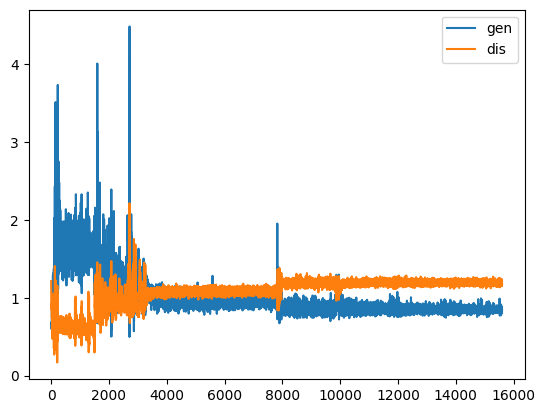

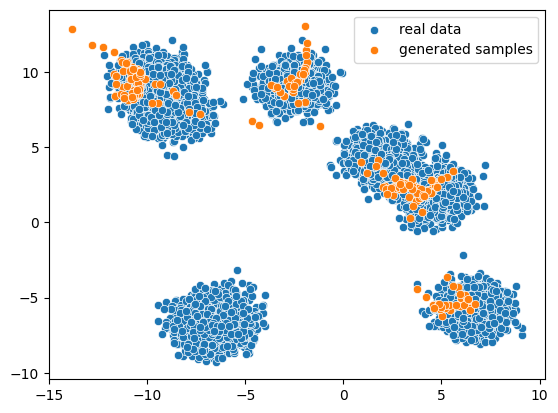

 50%|████▉     | 499/1000 [07:40<07:34,  1.10it/s]

------------------------------ epoch 499 ------------------------------


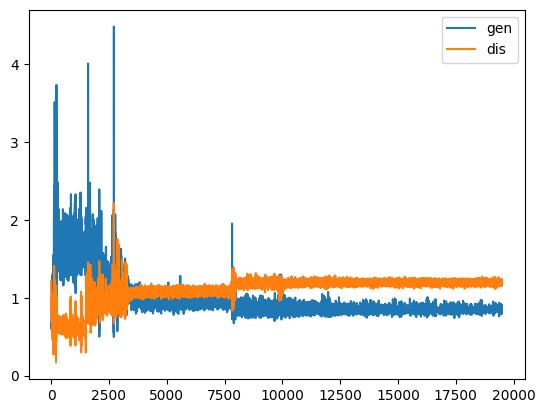

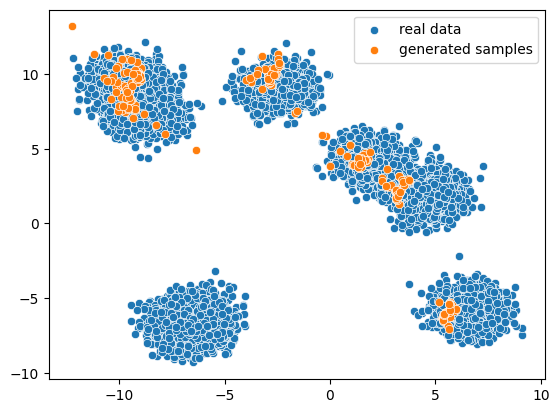

 60%|█████▉    | 599/1000 [09:31<07:15,  1.09s/it]

------------------------------ epoch 599 ------------------------------


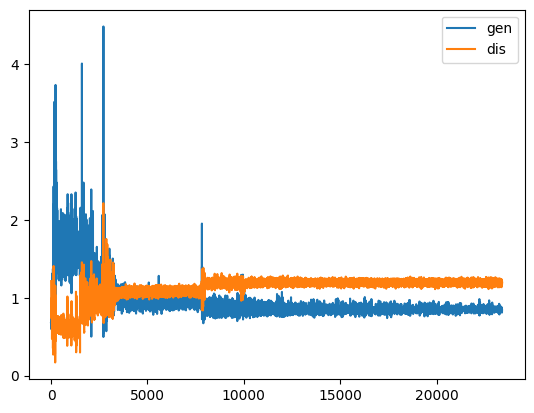

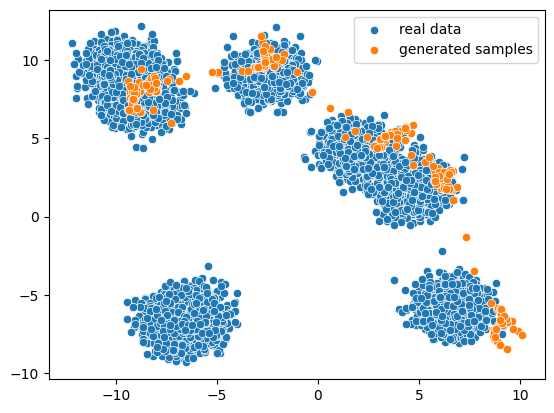

 70%|██████▉   | 699/1000 [11:07<04:23,  1.14it/s]

------------------------------ epoch 699 ------------------------------


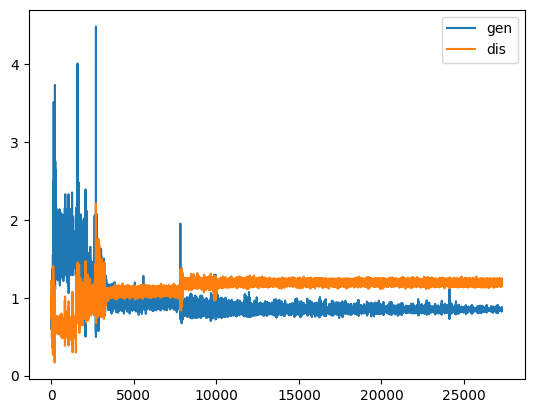

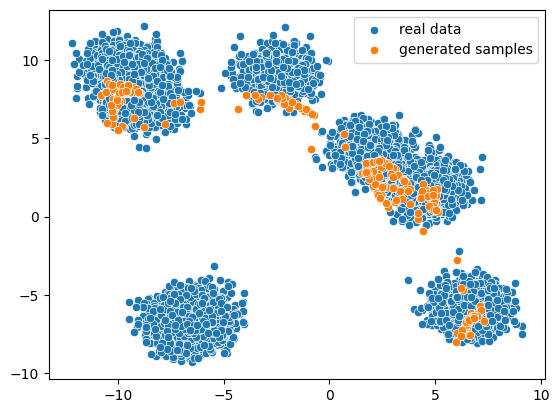

 80%|███████▉  | 799/1000 [12:35<02:55,  1.15it/s]

------------------------------ epoch 799 ------------------------------


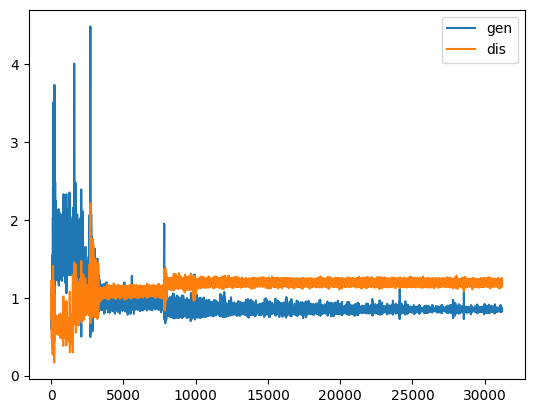

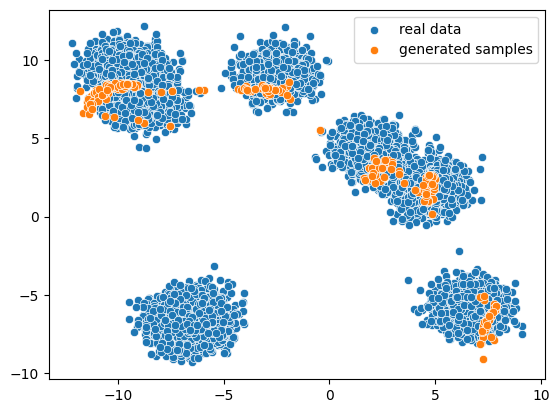

 90%|████████▉ | 899/1000 [14:03<01:22,  1.22it/s]

------------------------------ epoch 899 ------------------------------


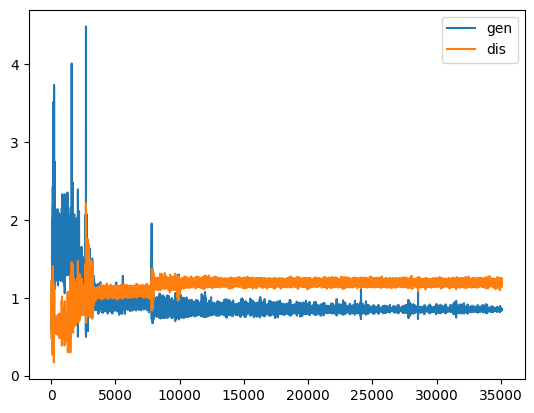

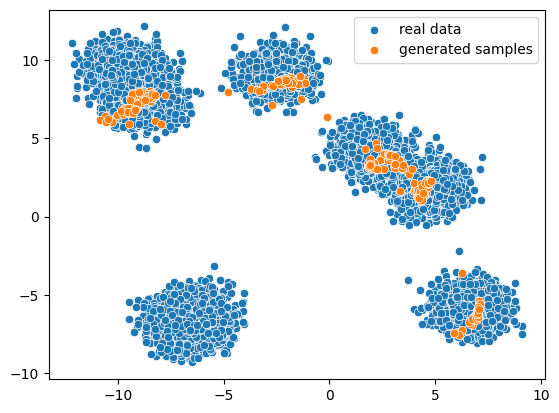

100%|█████████▉| 999/1000 [15:33<00:00,  1.07it/s]

------------------------------ epoch 999 ------------------------------


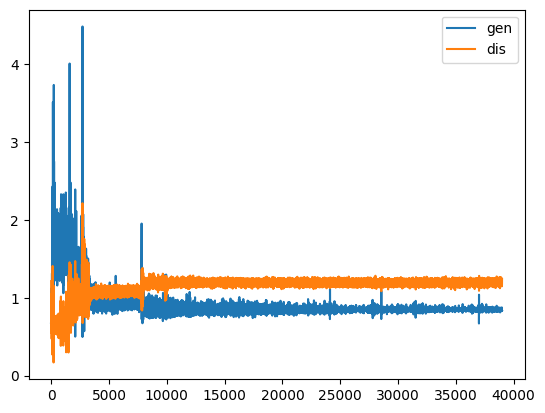

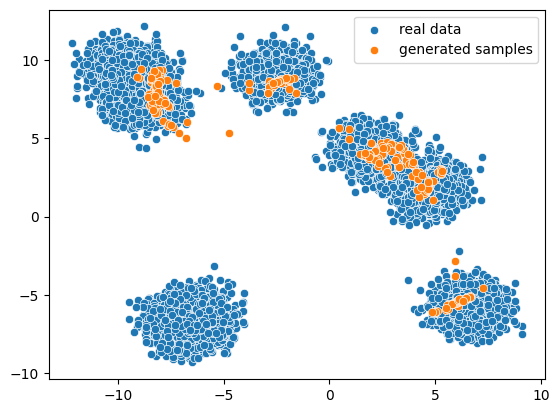

100%|██████████| 1000/1000 [15:36<00:00,  1.07it/s]


In [133]:
hparams = OmegaConf.create({
    'epochs': 1000,
    'batch_size': 256,
    'gen_lr': 0.0001,
    'dis_lr': 0.0001,
    'beta1': 0.5,  # NOTE: important!
    'model_type': 'mlp',
    'generator': {
        'n_layers': 5,
        'hidden_dim': 512,
    },
    'discriminator': {
        'n_layers': 4,
        'hidden_dim': 512,
    },
    'input_noise_dim': 2,
})
create_and_train_gan(hparams, dataset_blobs(n_samples=10000, seed=seed), seed=seed)

If you get a similar result feel free to play with the hyperparameter values!
Which of them seem important? Which of them the model is not so sensitive?

You can also try to change the random seed and see if the results change significantly. Do the results seem more consistent across different seeds for different hyperparamer settings?

## (Task) Train the GAN model: Swiss roll data

Now, let's try a slightly difficult problem!

In [ ]:
hparams = OmegaConf.create({
    'epochs': 1000,
    'batch_size': 256,
    'gen_lr': 0.0001,
    'dis_lr': 0.0001,
    'beta1': 0.5,  # NOTE: important!
    'model_type': 'mlp',
    'generator': {
        'n_layers': 3,
        'hidden_dim': 512,
    },
    'discriminator': {
        'n_layers': 2,
        'hidden_dim': 512,
    },
    'input_noise_dim': 2,
})

create_and_train_gan(hparams, dataset_swiss_roll(n_samples=10000, seed=seed), seed=seed)

As you see the model (with the original hyperparameter values) is not really able to model the data well :/

Are you able to improve the model to get a results like the following figure?

![Swiss roll](./imgs/step1_swiss_roll.png)

**Here are some sugestions what to try:**
- Different hparams, architecture
- Updating the discriminator more often than the generator (e.g. 5 updates)
- Different initialization of weights (e.g. Normal with std = 0.02)
- Different GAN objectives ([WGAN](https://arxiv.org/abs/1701.07875),
[WGAN-GP](https://papers.nips.cc/paper/2017/hash/892c3b1c6dccd52936e27cbd0ff683d6-Abstract.html),
[LSGAN](https://openaccess.thecvf.com/content_ICCV_2017/papers/Mao_Least_Squares_Generative_ICCV_2017_paper.pdf))

Note that these are just suggestions! The point of them is to make you try out different things yourself. Some of them should help significantly, while others might not help much or even make things worse! You need to try them yourself to find out!

Finally, it is valuable for us to know, how long did it take you to finish this practical?